The idea is to experiment different regression models such as lm, lasso, rf, etc along with the caret preprocess function. 
The database contains observations of weights and diameters of peaches.
The "true" relationship is a cubic function Weight=pulpDensity*(constant*(D)^3) + seedWeight.

Peach weight is the response variable.

# Data wrangling

In [83]:
library(tidyverse, warn.conflicts = F, quietly = T)
library(caret, warn.conflicts = F, quietly = T)
library(doParallel, warn.conflicts = F, quietly = T)
library(drc, warn.conflicts = F, quietly = T)
library(dbscan, warn.conflicts = F, quietly = T)
library(robust, warn.conflicts = F, quietly = T)

In [3]:
Data<-read_csv("duraznosfinal.csv")

New names:
* `` -> ...1

Rows: 1186 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): ...1, Zona, Finca, Peso, Diámetro Sutural, Diámetro Contrasutural

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
str(Data)

spec_tbl_df [1,186 × 6] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1                  : num [1:1186] 1 2 3 4 5 6 7 8 9 10 ...
 $ Zona                  : num [1:1186] 1 1 1 1 1 1 1 1 1 1 ...
 $ Finca                 : num [1:1186] 301 1502 301 301 1502 ...
 $ Peso                  : num [1:1186] 147 87 139 159 128 83 94 129 105 125 ...
 $ Diámetro Sutural      : num [1:1186] 64 57 65 69 64 56 57 63.7 60 63 ...
 $ Diámetro Contrasutural: num [1:1186] 67 53 64 67 62 52 55 62.1 59 61 ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1 = col_double(),
  ..   Zona = col_double(),
  ..   Finca = col_double(),
  ..   Peso = col_double(),
  ..   `Diámetro Sutural` = col_double(),
  ..   `Diámetro Contrasutural` = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [5]:
Data$`...1`<-NULL
Data$Zona<-as.factor(Data$Zona)
Data$Finca<-as.factor(Data$Finca)
Data<-rename(Data,"DS"="Diámetro Sutural");
Data<-rename(Data,"DCS"="Diámetro Contrasutural");

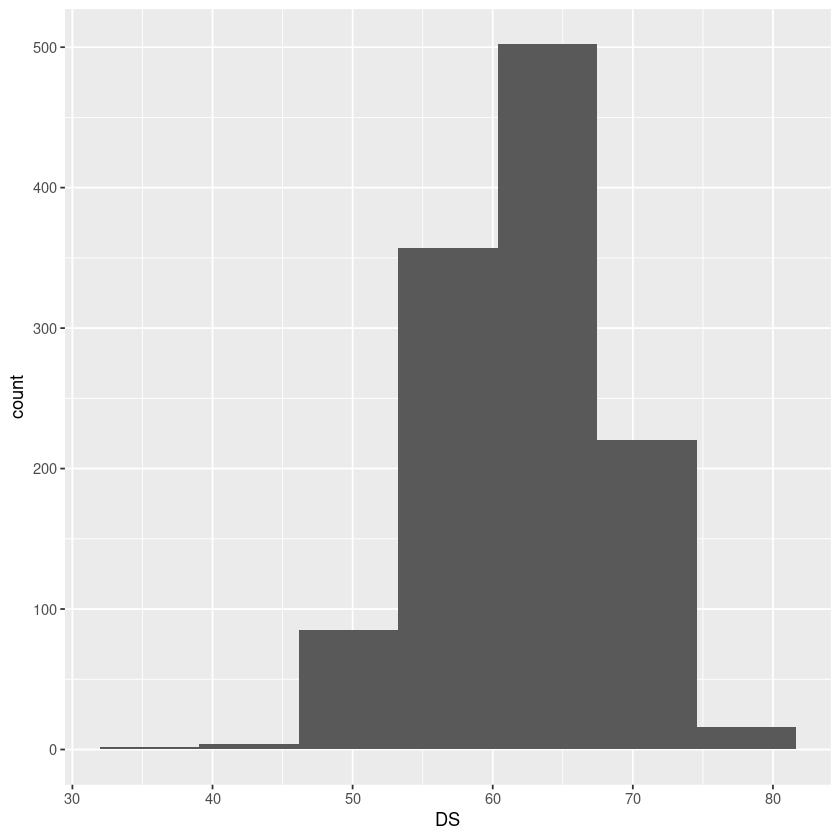

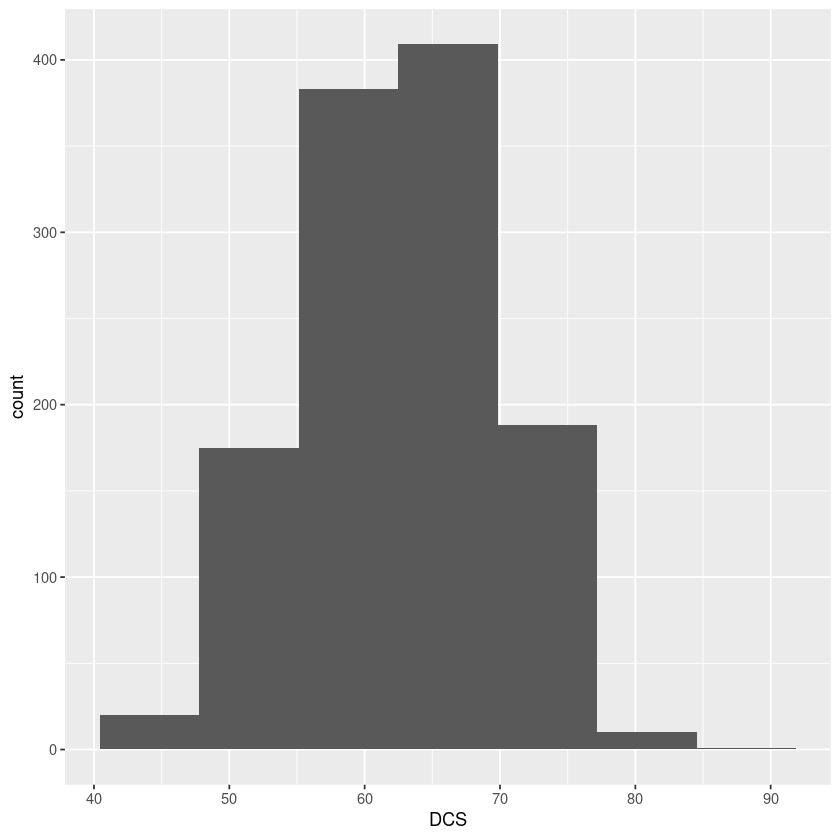

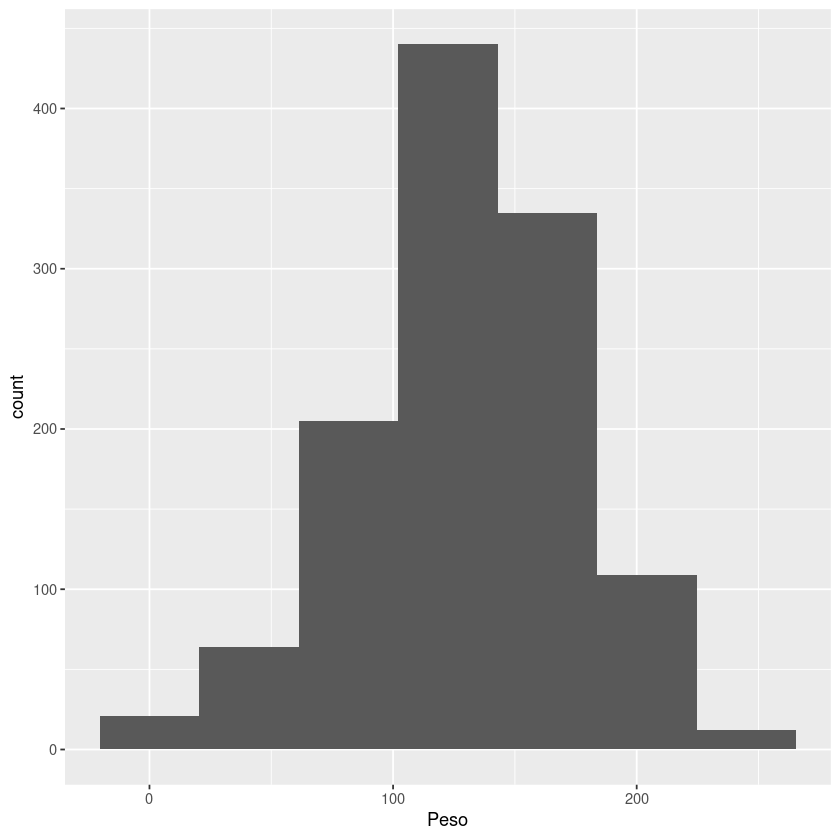

In [5]:
ggplot(data=Data,aes(DS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(DCS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(Peso))+
geom_histogram(bins=7)



  1   2   3 
606 200 380 


  101   102   201   301   303   401   501   601   701   801   901   902  1002 
   20   106    20   200    20    20    20    20    20    20    20    50    50 
 1032  1101  1201  1301  1401  1502  1601  1701  1801  1901 40801 40901 
   20    20    20    20    20   220    20    20    20    20   100   100 

`summarise()` has grouped output by 'Zona'. You can override using the
`.groups` argument.


Zona,Finca,n,mean,sd
<fct>,<fct>,<int>,<dbl>,<dbl>
1,102,106,133.3774,25.29463
1,301,200,119.2400,27.61295
1,902,50,161.4400,22.74271
1,1002,50,173.7400,31.22519
1,1502,200,122.0150,27.67752
2,40801,100,48.4000,34.36935
2,40901,100,161.3000,31.74727
3,101,20,106.3000,16.65470
3,201,20,158.3500,22.48573


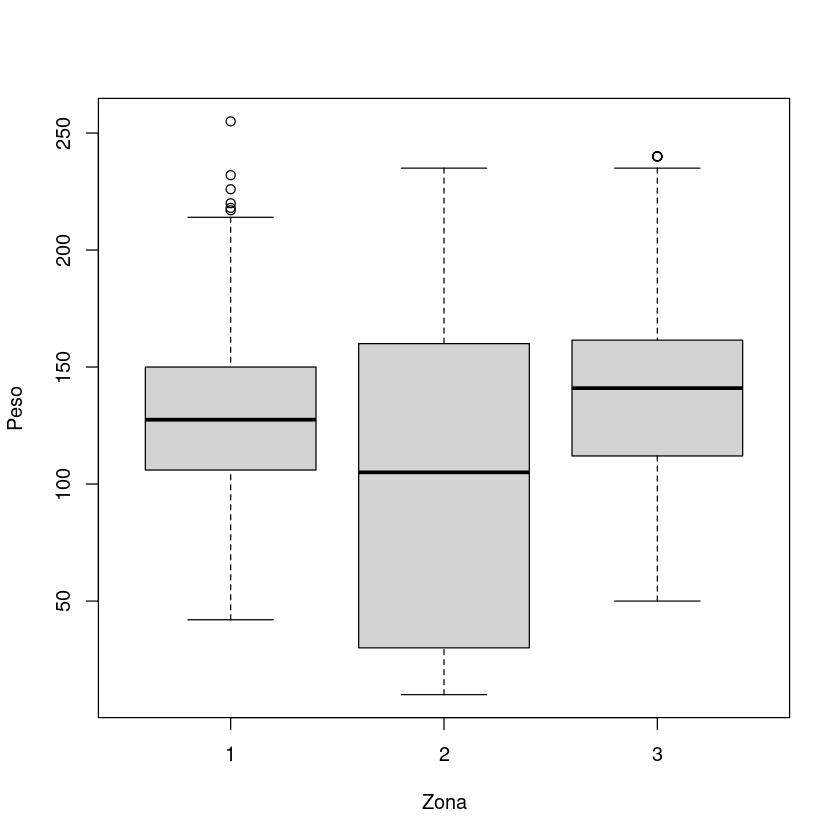

[1] "Zona"  "Finca" "Peso"  "DS"    "DCS"

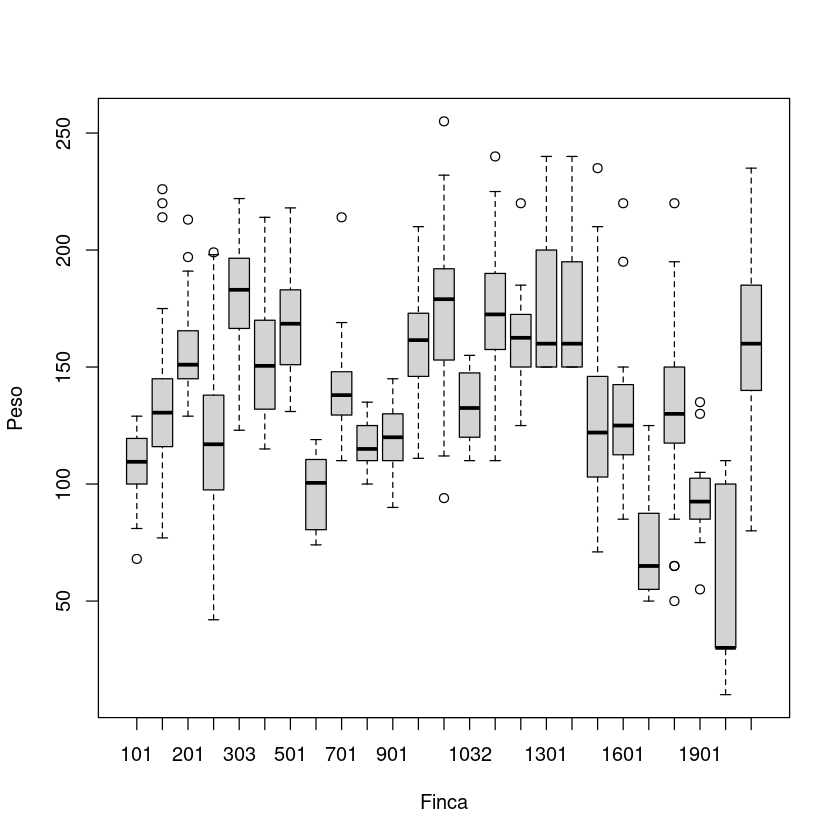

In [147]:
table(Data$Zona)
table(Data$Finca)
Data%>%group_by(Zona,Finca)%>%summarise(n=n(),mean=mean(Peso),sd=sd(Peso))

boxplot(Peso~Zona,data=Data)
boxplot(Peso~Finca,data=Data)


names(Data)
#xform to numerical space
dummies <- dummyVars(Peso ~ Zona+Finca, data = Data)
oneHot<-predict(dummies, newdata = Data)
CleanData<-Data%>%dplyr::select(-Zona,-Finca)%>%cbind(as.data.frame(oneHot[,1:3]),as.data.frame(oneHot[,4:28]))

#preProcValues <- preProcess(CleanData, method = c("center", "scale"))
#CleanData<-predict(preProcValues, CleanData)

# Outlier detection via RobustPCA

levels
inlier     OD  OD+SD     SD 
   968    136     70     12 

       OD
SD      FALSE TRUE
  FALSE    70   12
  TRUE    136  968

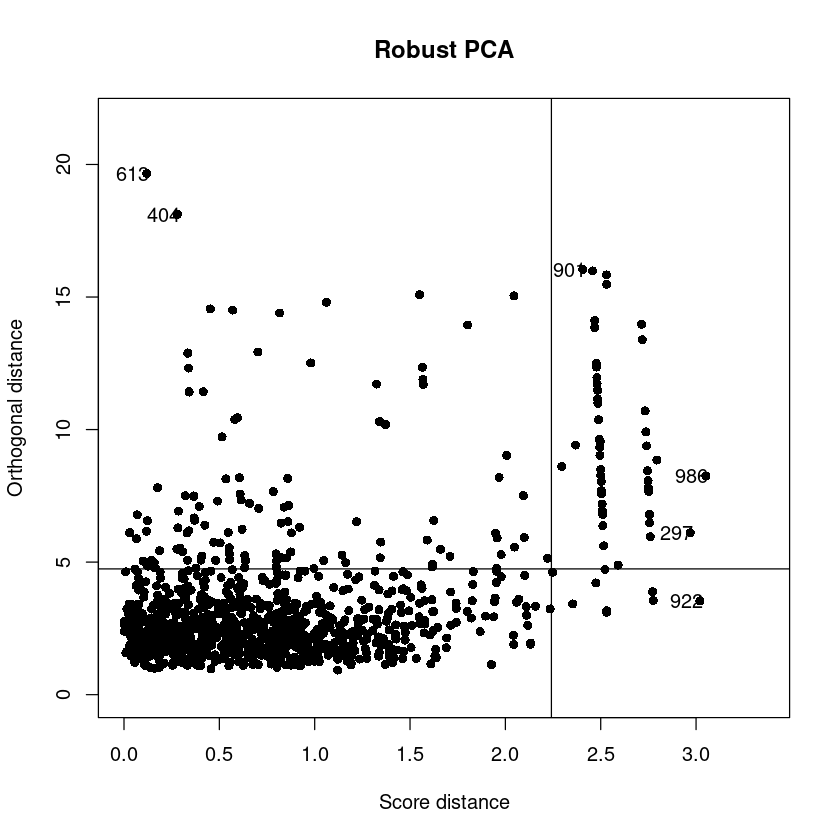

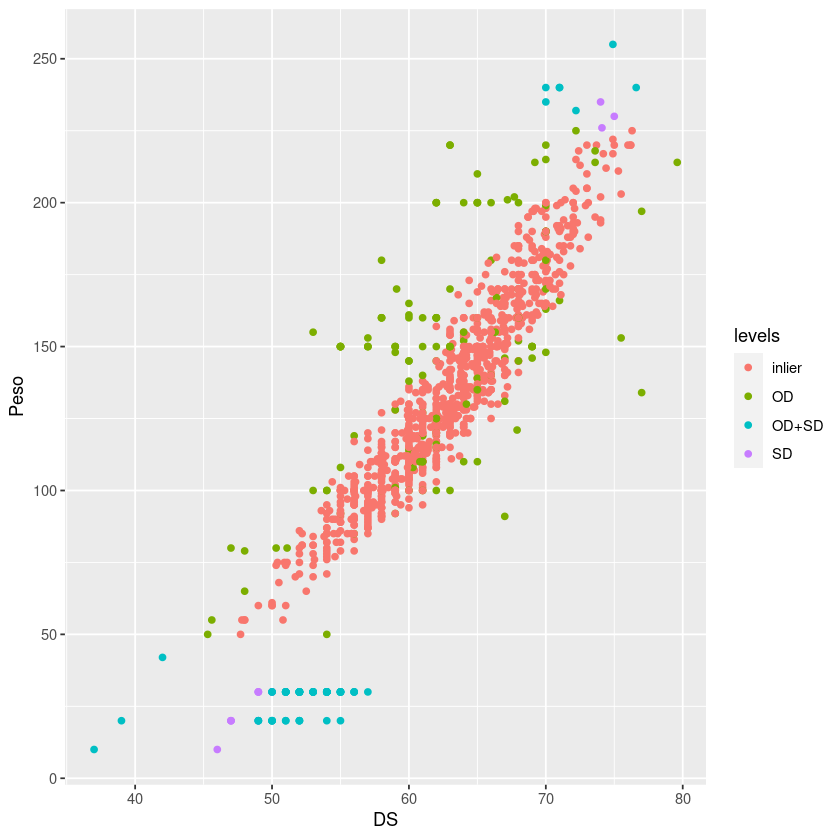

In [148]:
resR <- rospca::robpca(CleanData, kmax=20, ndir=5000)
rospca::diagPlot(resR)
levels<-ifelse(
    !resR$flag.od&!resR$flag.sd,'OD+SD',ifelse(!resR$flag.od,'OD',ifelse(!resR$flag.sd,'SD','inlier'))
)
#     ifelse(
#             !resR$flag.sd,'SD','inlier')
#     )


table(levels)        
table(SD=resR$flag.sd,OD=resR$flag.od)
ggplot(data=CleanData,aes(x=DS,y=Peso,color=levels))+geom_point()
# CleanData<-CleanData%>%mutate(outlierTag=resR$flag.od)

# Outliers via PCA reconstruction 

 num [1:1186, 1:31] -0.598 1.491 -0.381 -1.145 -0.174 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:1186] "1" "2" "3" "4" ...
  ..$ : chr [1:31] "PC1" "PC2" "PC3" "PC4" ...


[1] 0.9839979


 inlier outlier 
   1179       7 

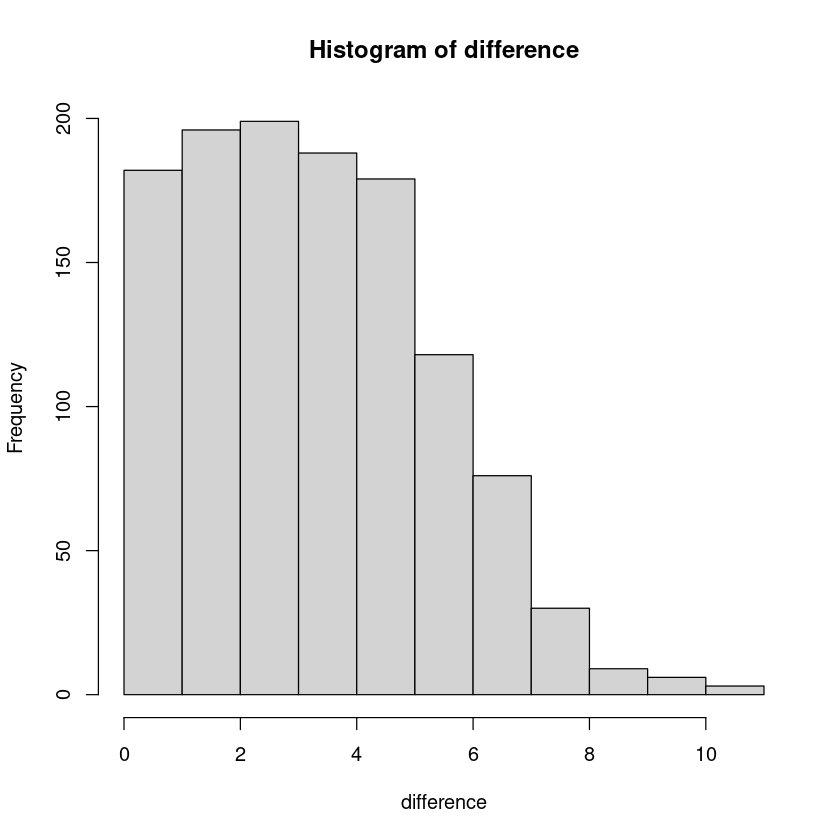

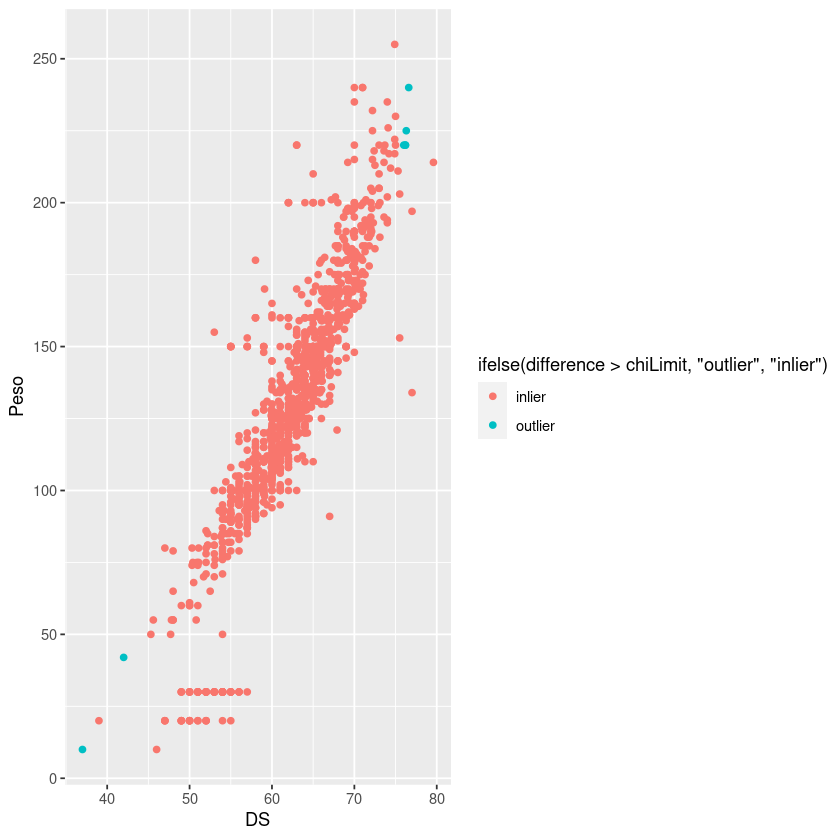

In [175]:
library(factoextra)
res.pca <- prcomp(CleanData, center=TRUE, scale = TRUE) #uses correlation matrix
# res.pca <- prcomp(CleanData) 
# mu <- colMeans(CleanData)
str(res.pca$x)
components<-26

# PCScores<-res.pca$x[,1:components]
# PCEigen<-res.pca$rotation[,1:components]
PCScores<-res.pca$x[,components:31]
PCEigen<-res.pca$rotation[,components:31]

sum(res.pca$sdev[1:components])/sum(res.pca$sdev)

reconstrData <- as.matrix(PCScores)%*%t(as.matrix(PCEigen))

difference <- sqrt(rowSums(scale(CleanData,center=TRUE,scale=TRUE)-reconstrData)^2)
hist(difference)
# length(difference)
chiLimit<-qchisq(0.9,df=31-components)
#str(res.pca$x)

table(ifelse(difference>chiLimit,'outlier','inlier'))

ggplot(data=CleanData,aes(x=DS,y=Peso,color=ifelse(difference>chiLimit,'outlier','inlier')))+geom_point();

# Robust covariance estimation and Mahalanobis distance

In [150]:
res.pca$scale
robustCov<-(covRob(res.pca$x));

pval<-pchisq(robustCov$dist,df=components,lower.tail=FALSE)
hist(pval)

# robModel<-lmRob(data=CleanData,Peso~DS+DCS)
# summary(robModel)

Peso          DS         DCS      Zona.1      Zona.2      Zona.3 
 43.3544274   6.0075676   6.9815754   0.5000907   0.3745863   0.4668290 
  Finca.101   Finca.102   Finca.201   Finca.301   Finca.303   Finca.401 
  0.1288139   0.2854061   0.1288139   0.3745863   0.1288139   0.1288139 
  Finca.501   Finca.601   Finca.701   Finca.801   Finca.901   Finca.902 
  0.1288139   0.1288139   0.1288139   0.1288139   0.1288139   0.2010355 
 Finca.1002  Finca.1032  Finca.1101  Finca.1201  Finca.1301  Finca.1401 
  0.2010355   0.1288139   0.1288139   0.1288139   0.1288139   0.1288139 
 Finca.1502  Finca.1601  Finca.1701  Finca.1801  Finca.1901 Finca.40801 
  0.3888646   0.1288139   0.1288139   0.1288139   0.1288139   0.2779799 
Finca.40901 
  0.2779799

ERROR: Error in CovOgk(data, control = CovControlOgk(smrob = "s_mad", svrob = "qc")): column with zero scale encountered in C function covOPW


In [151]:
# ggplot(data=Data,aes(x=DS,y=Peso,color=robustCov$dist))+geom_point()

In [12]:
# #Mahalanobis score (Aggarwal)
# D<-CleanData
# Dp<-as.matrix(D)%*%(res.pca$rotation)
# Dpscaled<-scale(Dp,center=FALSE,scale=TRUE)
# Scores<-sqrt(rowSums(scale(Dp,center=TRUE,scale=FALSE)^2))
# hist(Scores)

# Scores <- mahalanobis(CleanData, colMeans(CleanData), cov(CleanData))
# hist(Scores)


In [13]:
# X=CleanData;

# #reconstructing observations from PC subspace
# #outlier score = norm(X-Xreconstructed)
# pc.use <- 20 #using 1 PC for reconstruction
# print(c("variance explained:",sum(res.pca$sdev[1:pc.use]^2/sum(res.pca$sdev^2))))

# Xrecon<- res.pca$x[,1:pc.use]%*%t(res.pca$rotation[,1:pc.use]) #mmult transpose
# Xrecon<-scale(Xrecon,center=FALSE, scale=1/res.pca$scale)
# Xrecon<-scale(Xrecon,center=-1*res.pca$center,scale=FALSE)

# diff=abs(X-Xrecon)
# score<-rowSums(diff)

# # score<-diff%>%rowwise()%>%mutate(score=sqrt(sum(c_across(1:6)^2)))

# # dim(diff)
      
# # score<-rowSums(diff%*%t(pr.out$sdev[1:pc.use]))
# # score

# # w_1st.pc=sum(pr.out$sdev[1])
# # w_all.pc=sum(pr.out$sdev)
# # w=w_1st.pc/w_all.pc
# # score=rowSums(diff*w)

# # hist(score) #Chi-sq

# # uppr<-qchisq(0.95,df=31)
# # indexPC<-names(score[score>uppr])

# Q<-quantile(score,c(0.25,0.75))
# IQR<-Q[2]-Q[1]
# uppr<-Q[2]+1.5*IQR
# lwr<-Q[1]-1.5*IQR

# indexPC<-names(score[score>uppr|score<lwr])
# table(which(score>uppr|score<lwr))

# table(names(score)%in%indexPC)
# ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(names(score)%in%indexPC,"outlier","expected")))+
# geom_point()

# #########


# # outliersScores<-sqrt(rowSums(PCSpace^2))
# # boxplot(outliersScores)
# # hist(outliersScores)
# # Q<-quantile(outliersScores,c(0.25,0.75))
# # IQR<-Q[2]-Q[1]
# # uppr<-Q[2]+1.5*IQR
# # lwr<-Q[1]-1.5*IQR
# # uppr
# # lwr


# # outlierIndex<-names(outliersScores[outliersScores>uppr|outliersScores<lwr])
# # table(names(outliersScores)%in%outlierIndex)
# # ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(names(outliersScores)%in%outlierIndex,"outlier","expected")))+
# # geom_point()

# # outlierIndex<-order(outliersScores[outliersScores>uppr|outliersScores<lwr])
# # ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(order(outliersScores)%in%outlierIndex,"outlier","expected")))+
# # geom_point()

# DBScan on PC space


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 85 195 199  99  47  46  20  69  20  99  29  19   3  19  15  18  13  16  12  14 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36 
 17  15  20  15  13   3  12  10   3   6  13   4   6   3   3   3   3 

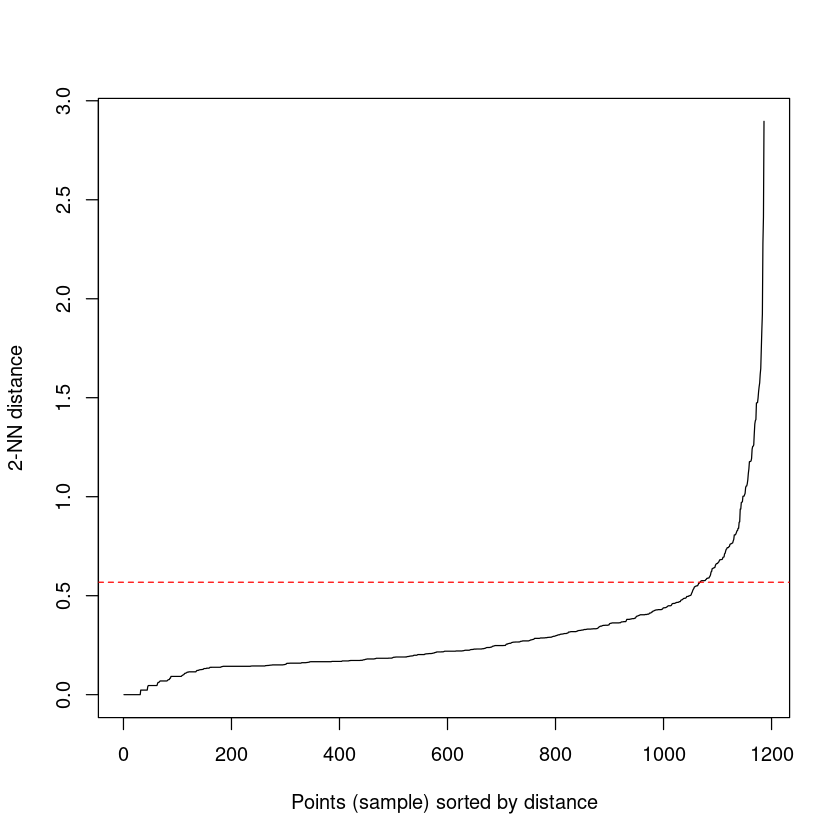

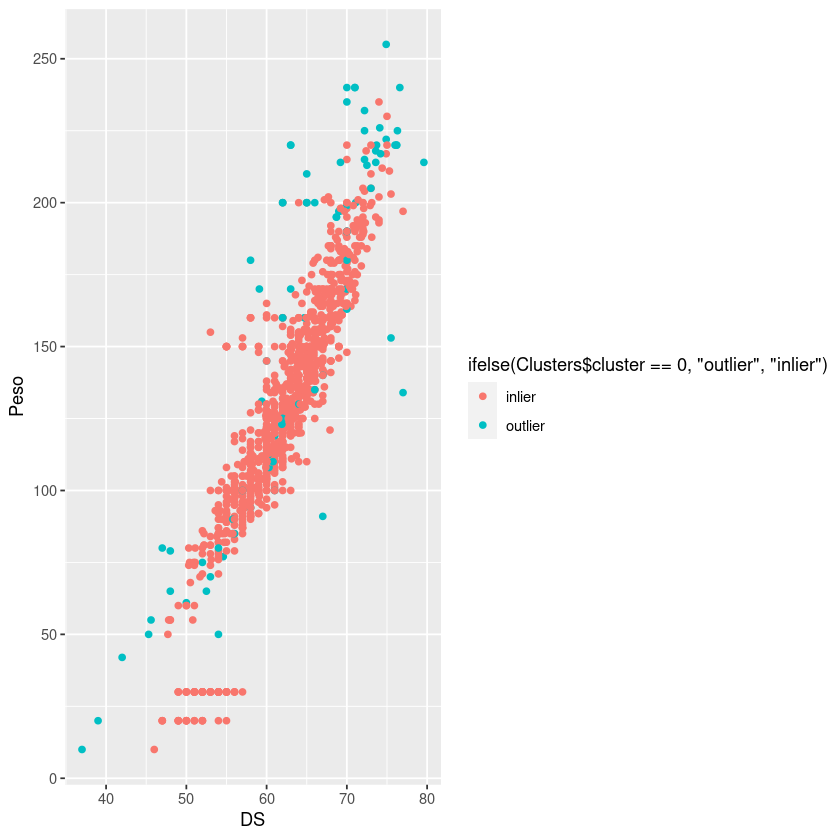

In [157]:
#Looking for density based outliers
WorkData<-res.pca$x;

#Choosing eps value
#Calculate distances between transactions using kNN algorithm and aggregate by breaks,
#k=MinPts-1=3-1, MinPts=dimensionality-1
MinPts=3;
k=MinPts-1;
#plot maximum kNN distance distribution, points are ordered in increasing kNN distance.
kNNdistplot(WorkData, k = 2);
eps=quantile(kNNdist(WorkData, k = 2),0.9);
#eps = 0.08
#Select eps value at the curve \"knee\"\
abline(h=eps, col = "red", lty=2);

# #Label outliers using DBSCAN algorithm, output$cluster holds the results, 0 indicates \"noise points\" https://cran.r-project.org/web/packages/dbscan/dbscan.pdf\n",
Clusters <- dbscan(WorkData, eps = eps, minPts = 3);

# Data<-Data%>%mutate(DBClusters=Clusters$cluster)
table(as.factor(Clusters$cluster))

ggplot(data=Data, aes(x=DS,y=Peso,color=ifelse(Clusters$cluster==0,'outlier','inlier')))+
geom_point();

In [15]:
# table(as.factor(Data$DBClusters))
# 1186-1004

# ggplot(data=Data, aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# geom_point();

# ggplot(data=Data%>%filter(!DBClusters=="1"), aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# geom_point();

In [16]:
# indexDBScan<-which(!Data$DBClusters=="1") #not in Cluster 1
# # ggplot(data=Data[indexDBScan,], aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# # geom_point();
#  indexOutlier<-unique(c(indexDBScan,indexPC))

# # indexOutlier<-indexDBScan

# table(!order(Data$Zona)%in%indexOutlier)

# CleanData<-Data[!seq(1,1186)%in%indexOutlier,]

# dim(CleanData)

# # CleanData<-Data%>%dplyr::filter(DBClusters==1)

In [17]:
# ggplot(data=CleanData,aes(x=DS,y=Peso))+
# geom_point()

# Feature selection

In [177]:
ModelData<-CleanData%>%filter(resR$flag.all==TRUE)
str(ModelData)
#Compressing numerical variables into categorical
print(c("Sturges Classes:",SturgesBins<-round(1+log2(length(ModelData$Peso)),0)))

#"cut" splits data by range, "ntile" splits data by quantiles

#DSBinnedMids<-hist(CleanData$DS,plot=FALSE)$mids
#DCSBinnedMids<-hist(CleanData$DCS,plot=FALSE)$mids

ModelData<-ModelData%>%mutate(
    DSBinned=(cut(ModelData$DS,SturgesBins,labels=FALSE)),
    DCSBinned=(cut(ModelData$DCS,SturgesBins,labels=FALSE))
)

'data.frame':	968 obs. of  33 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ DS         : num  64 57 65 69 64 56 57 63.7 60 63 ...
 $ DCS        : num  67 53 64 67 62 52 55 62.1 59 61 ...
 $ Zona.1     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Zona.2     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Zona.3     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : nu

In [30]:
# #Since zona and finca are nominal, they are one-hot encoded. 
# dummies <- dummyVars(Peso ~ Zona+Finca, data = CleanData)
# oneHot<-predict(dummies, newdata = CleanData)
# CleanData<-CleanData%>%cbind(as.data.frame(oneHot[,1:3]),as.data.frame(oneHot[,4:28]))

# #Moreover, Binned variables are ordinal, therefore they are standarised.
# features<-CleanData[,7:8];

# preProcValues <- preProcess(features, method = c("center", "scale"))
# stdFeatures<-predict(preProcValues, features)
# CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [178]:
# WorkData<-CleanData%>%filter(outlierTag==TRUE)%>%dplyr::select(Peso,starts_with("Finca."),starts_with("Zona."),ends_with("Binned"))
WorkData<-ModelData%>%dplyr::select(Peso,starts_with("Finca."),starts_with("Zona."),ends_with("Binned"))
str(WorkData)

'data.frame':	968 obs. of  31 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502 : num  0 1 0 0 1 0 1 0 1 0 ...
 $ Finca.1601 : num  0 0 0 0 0 0 0 0 0 0 .

In [179]:
descrCor <-  cor(WorkData%>%dplyr::select(-Peso))
findCorrelation(descrCor, cutoff = .75,verbose=TRUE,names=TRUE)

Compare row 26  and column  28 with corr  0.776 
  Means:  0.211 vs 0.065 so flagging column 26 
Compare row 30  and column  29 with corr  0.911 
  Means:  0.136 vs 0.057 so flagging column 30 
Compare row 27  and column  25 with corr  0.88 
  Means:  0.116 vs 0.052 so flagging column 27 
All correlations <= 0.75 


[1] "Zona.1"    "DCSBinned" "Zona.2"

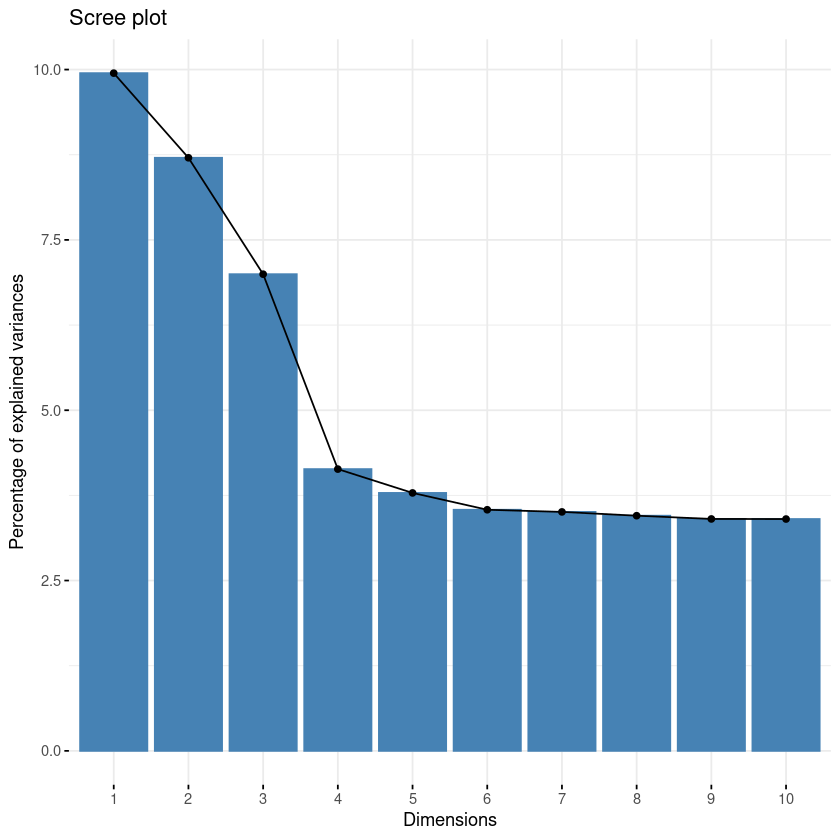

In [180]:
library(factoextra)
res.pca <- prcomp(WorkData%>%dplyr::select(-Peso), scale = TRUE) #uses correlation matrix
fviz_eig(res.pca)

WorkData<-cbind(WorkData,res.pca$x)

#preProcValues <- preProcess(WorkData%>%dplyr::select(-Peso), method = c("pca"))
#PCFeatures<-predict(preProcValues, WorkData%>%dplyr::select(-Peso))
#str(PCFeatures)
#CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [181]:
str(WorkData)

'data.frame':	968 obs. of  61 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502 : num  0 1 0 0 1 0 1 0 1 0 ...
 $ Finca.1601 : num  0 0 0 0 0 0 0 0 0 0 .

In [182]:
eig.val <- get_eigenvalue(res.pca)
head(eig.val)

,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,2.984242,9.947472,9.947472
Dim.2,2.611585,8.705283,18.652756
Dim.3,2.098961,6.996538,25.649293
Dim.4,1.240666,4.135555,29.784848
Dim.5,1.135789,3.785964,33.570813
Dim.6,1.061685,3.538950,37.109763


In [183]:
#Sampling
set.seed(3456)
trainIndex <- createDataPartition(WorkData$Peso, p = .5, 
                                  list = FALSE, 
                                  times = 1)

trainData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Binned")))[trainIndex,];

testData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Binned")))[-trainIndex,];


Call:
lm(formula = Peso ~ ., data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.4212  -4.5794   0.3576   4.6442  26.0346 

Coefficients: (1 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  34.1301     2.0047  17.025  < 2e-16 ***
Finca.101     0.7007     2.8041   0.250 0.802783    
Finca.102     0.9413     1.5856   0.594 0.553046    
Finca.201     8.4508     2.7173   3.110 0.001987 ** 
Finca.301     2.5988     1.4055   1.849 0.065097 .  
Finca.303    12.1514     2.4349   4.991 8.57e-07 ***
Finca.401     3.5809     3.0398   1.178 0.239395    
Finca.501     9.9669     2.8679   3.475 0.000559 ***
Finca.601    11.2294     2.5988   4.321 1.91e-05 ***
Finca.701    11.0317     2.8941   3.812 0.000157 ***
Finca.801    -5.2598     3.0715  -1.712 0.087491 .  
Finca.901    -5.0636     3.5335  -1.433 0.152530    
Finca.902     4.8639     1.8201   2.672 0.007801 ** 
Finca.1002    5.2160     2.1478   2.429 0.015543 *

Warning message:
“not plotting observations with leverage one:
  433, 450”


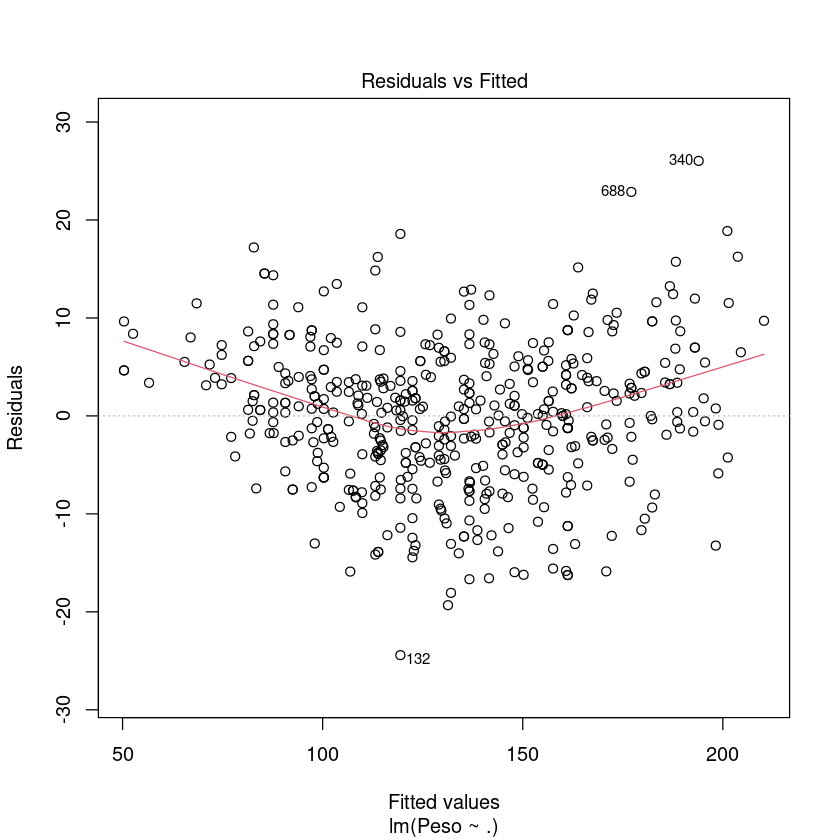

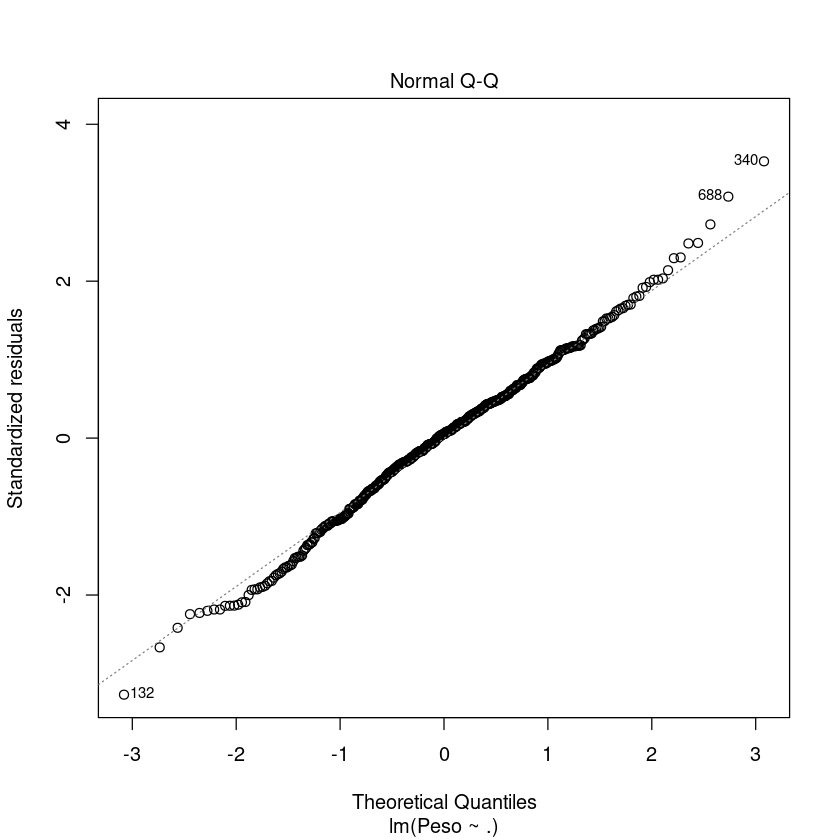

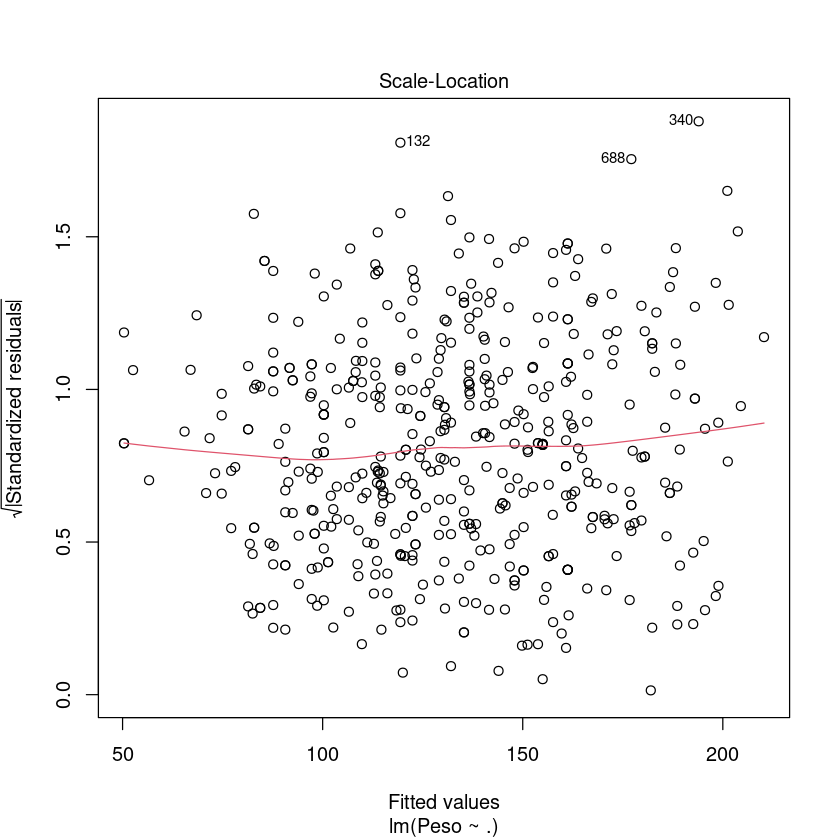

Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


[1] "Root Mean Squared Error:" "8.09517992106875"        


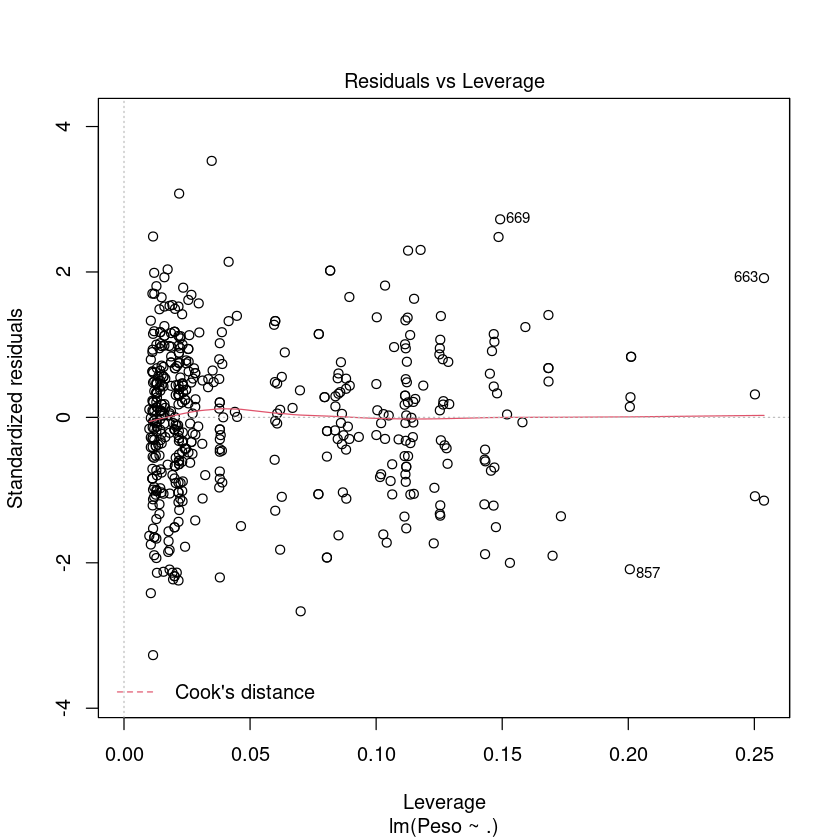

In [184]:
#Baseline model
lm0<-lm(data=trainData,Peso~.)
summary(lm0)
plot(lm0)
PesoPredict<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE<-sqrt(sum((PesoPredict[,1]-testData$Peso)^2)/length(testData$Peso))
print(c("Root Mean Squared Error:",RMSE))

In [186]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=10,
                data=trainData,
                method="glmnet"               
                );
stopCluster(cl)
modelLasso

glmnet 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 436, 437, 435, 436, 437, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE       Rsquared   MAE      
  0.1     0.03406871   7.774249  0.9469919   6.129370
  0.1     0.07870314   7.774249  0.9469919   6.129370
  0.1     0.18181446   7.774249  0.9469919   6.129370
  0.1     0.42001498   7.767680  0.9470758   6.123308
  0.1     0.97028907   7.770379  0.9471213   6.125929
  0.1     2.24149360   7.840628  0.9470035   6.172196
  0.1     5.17814095   8.318519  0.9452823   6.557436
  0.1    11.96217719   9.922915  0.9417180   7.888894
  0.1    27.63418080  13.858628  0.9389105  11.386795
  0.2     0.03406871   7.765539  0.9470902   6.126209
  0.2     0.07870314   7.765539  0.9470902   6.126209
  0.2     0.18181446   7.764138  0.9471076   6.125204
  0.2     0.42001498   7.744065  0.9473228   6.113964
  0.2     0.97028907   7.742225  0.9473366   

In [187]:
train_control <- trainControl(method = "cv",number = 10)

trainDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[trainIndex,];
testDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[-trainIndex,];

cl <- makeCluster(2)
registerDoParallel(cl)
modelPC <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainDataPC,
                method="leapBackward"
                );
stopCluster(cl)
print(modelPC)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
“4  linear dependencies found”


Linear Regression with Backwards Selection 

485 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 436, 437, 438, 436, 437, 436, ... 
Resampling results across tuning parameters:

  nvmax  RMSE        Rsquared   MAE      
   2       20.55454  0.6213750   17.10794
   3       14.03567  0.8003804   11.21237
   4      651.79465  0.7552137   99.58555
   5      712.30175  0.7567365  107.95991
   6      752.31742  0.7600225  113.26916
   7      791.60808  0.7586005  119.00490
   8      839.85894  0.7591503  125.78046
   9      887.89787  0.7608567  132.34289
  10      895.80520  0.7614392  133.49449
  11      909.96047  0.7624923  135.48794
  12      919.96201  0.7619634  136.91075
  13      931.74023  0.7615527  138.61559
  14      944.48520  0.7612983  140.38870
  15      950.72818  0.7614548  141.25272
  16      957.06696  0.7609025  142.13337
  17      959.43715  0.7611362  142.39031
  18      960.69265  0.7611121  142.56474
  19     

In [188]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelPCLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=10,
                data=trainDataPC,
                method="glmnet"               
                );
stopCluster(cl)
modelPCLasso

glmnet 

485 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 437, 435, 437, 436, 437, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE       Rsquared   MAE      
  0.1     0.02338476   7.857309  0.9454086   6.102960
  0.1     0.05402182   7.857309  0.9454086   6.102960
  0.1     0.12479741   7.857309  0.9454086   6.102960
  0.1     0.28829821   7.857399  0.9454494   6.096726
  0.1     0.66600626   7.878177  0.9455495   6.093201
  0.1     1.53856085   8.025272  0.9455626   6.196320
  0.1     3.55427512   8.722538  0.9446952   6.779041
  0.1     8.21083651  10.953802  0.9411143   8.695772
  0.1    18.96809729  15.825332  0.9326976  12.987032
  0.2     0.02338476   7.766511  0.9469965   6.071742
  0.2     0.05402182   7.766511  0.9469965   6.071742
  0.2     0.12479741   7.766511  0.9469965   6.071742
  0.2     0.28829821   7.761214  0.9471757   6.059245
  0.2     0.66600626   7.786336  0.9474274   

In [189]:
lm3<-lm(data=trainData,Peso~I((DSBinned+DCSBinned)/2^3))
summary(lm3)
PesoPredictLm3<-predict(lm3,testData)
summary(PesoPredictLm3)

RMSE<-sqrt(sum((PesoPredictLm3-testData$Peso)^2)/length(testData$Peso))

print(c("Polynomial Root Mean Squared Error:",RMSE))


Call:
lm(formula = Peso ~ I((DSBinned + DCSBinned)/2^3), data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.9204  -5.1068   0.4273   5.8000  24.2409 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     33.895      1.230   27.57   <2e-16 ***
I((DSBinned + DCSBinned)/2^3)   64.746      0.762   84.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.388 on 483 degrees of freedom
Multiple R-squared:  0.9373,	Adjusted R-squared:  0.9372 
F-statistic:  7220 on 1 and 483 DF,  p-value: < 2.2e-16


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.08  106.73  131.01  133.76  155.29  211.95 

[1] "Polynomial Root Mean Squared Error:" "8.45493193417288"                   


In [190]:
#Random forest

train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelRF <- train(Peso~.,
                data=trainData,
               # preProc=c("center","scale","nzv"),
                trControl = train_control,
                tuneLength=10,
                method="rf"               
                );
stopCluster(cl)

modelRF

Random Forest 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 436, 437, 437, 437, 436, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    15.672765  0.8659887  12.082283
   4    10.023603  0.9258632   7.913544
   7     8.142893  0.9454079   6.474522
  10     7.779692  0.9481327   6.183168
  13     7.706190  0.9483285   6.155442
  15     7.737311  0.9476813   6.184743
  18     7.746357  0.9473063   6.203545
  21     7.780962  0.9467496   6.247638
  24     7.797759  0.9464138   6.261521
  27     7.777843  0.9467177   6.239301

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 13.

In [191]:
#kNN

train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelkNN <- train(Peso~.,
                data=trainData,
               # preProc=c("center","scale","nzv"),
                trControl = train_control,
                tuneLength=10,
                method="knn"               
                );
stopCluster(cl)

modelkNN

k-Nearest Neighbors 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 436, 436, 437, 436, 437, 436, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   5  7.903677  0.9475365  6.244332
   7  7.901507  0.9479428  6.306721
   9  7.909611  0.9482608  6.346222
  11  7.921706  0.9484132  6.333805
  13  7.939013  0.9482399  6.361004
  15  8.001043  0.9479348  6.419889
  17  8.042331  0.9473532  6.452109
  19  8.130584  0.9462983  6.504682
  21  8.143561  0.9460034  6.491817
  23  8.202607  0.9450769  6.549424

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 7.

In [192]:
#print(c("Train results"))
RMSE<-matrix(1:14,nrow=7);

PesoPredictLM<-predict(lm0,trainData,interval="prediction",level=0.95)
RMSE[1,1]<-sqrt(sum((PesoPredictLM-trainData$Peso)^2)/length(trainData$Peso))
#print(c("Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictLasso<-predict(modelLasso,trainData)
RMSE[2,1]<-sqrt(sum((PesoPredictLasso-trainData$Peso)^2)/length(trainData$Peso))
#print(c("Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPC<-predict(modelPC,trainDataPC)
RMSE[3,1]<-sqrt(sum((PesoPredictPC-trainDataPC$Peso)^2)/length(trainDataPC$Peso))
#print(c("Principal Components Linear Model Root Mean Squared Error:",round(RMSE,2)))


PesoPredictPCLasso<-predict(modelPCLasso,trainDataPC)
RMSE[4,1]<-sqrt(sum((PesoPredictPCLasso-trainDataPC$Peso)^2)/length(trainDataPC$Peso))
#print(c("PC Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictRF<-predict(modelRF,trainData)
RMSE[5,1]<-sqrt(sum((PesoPredictRF-trainData$Peso)^2)/length(trainData$Peso))

PesoPredictkNN<-predict(modelkNN,trainData)
RMSE[6,1]<-sqrt(sum((PesoPredictkNN-trainData$Peso)^2)/length(trainData$Peso))

PesoPredictNL<-predict(lm3,trainData)
RMSE[7,1]<-sqrt(sum((PesoPredictNL-trainData$Peso)^2)/length(trainData$Peso))

#print(c("Random forest Root Mean Squared Error:",round(RMSE,2)))

#print(c("Test results"))

PesoPredictLM<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE[1,2]<-sqrt(sum((PesoPredictLM-testData$Peso)^2)/length(testData$Peso))
#print(c("Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictLasso<-predict(modelLasso,testData)
RMSE[2,2]<-sqrt(sum((PesoPredictLasso-testData$Peso)^2)/length(testData$Peso))
#print(c("Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPC<-predict(modelPC,testDataPC)
RMSE[3,2]<-sqrt(sum((PesoPredictPC-testDataPC$Peso)^2)/length(testDataPC$Peso))
#print(c("Principal Components Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPCLasso<-predict(modelPCLasso,testDataPC)
RMSE[4,2]<-sqrt(sum((PesoPredictPCLasso-testDataPC$Peso)^2)/length(testDataPC$Peso))
#print(c("PC Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictRF<-predict(modelRF,testData)
RMSE[5,2]<-sqrt(sum((PesoPredictRF-testData$Peso)^2)/length(testData$Peso))
#print(c("Random forest Root Mean Squared Error:",round(RMSE,2)))

PesoPredictkNN<-predict(modelkNN,testData)
RMSE[6,2]<-sqrt(sum((PesoPredictkNN-testData$Peso)^2)/length(testData$Peso))

PesoPredictNL<-predict(lm3,testData)
RMSE[7,2]<-sqrt(sum((PesoPredictNL-testData$Peso)^2)/length(testData$Peso))


RMSE<-cbind(model=c("Linear Model","Lasso","PC Linear","PC Lasso","RF","kNN","NL"),as.data.frame(RMSE));
rename(RMSE,"trainRMSE"=V1,"testRMSE"=V2);

Warning message in predict.lm(lm0, trainData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


model,trainRMSE,testRMSE
<chr>,<dbl>,<dbl>
Linear Model,24.899072,25.684838
Lasso,7.342925,8.046142
PC Linear,11.371321,11.728583
PC Lasso,7.324501,8.047219
RF,5.709270,7.917768
kNN,7.347170,8.276486
NL,8.371146,8.454932
